In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.5
pandas 1.0.4
sklearn 0.23.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [10]:
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.2))
# AlphaDropout相对于普通Dropout优势: 1. 均值和方差不变 2. 归一化性质也不变
# model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

In [12]:
len(model.layers)

23

In [13]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-selu-dropout-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8529 - accuracy: 0.7135 - val_loss: 0.5602 - val_accuracy: 0.8210
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5632 - accuracy: 0.8073 - val_loss: 0.4977 - val_accuracy: 0.8440
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4926 - accuracy: 0.8290 - val_loss: 0.4718 - val_accuracy: 0.8502
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4573 - accuracy: 0.8406 - val_loss: 0.4728 - val_accuracy: 0.8516
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4247 - accuracy: 0.8538 - val_loss: 0.4483 - val_accuracy: 0.8602
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4025 - accuracy: 0.8585 - val_loss: 0.4331 - val_accuracy: 0.8666
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3807 - accuracy: 0.8660 - val_loss: 0.4400 - val_accuracy

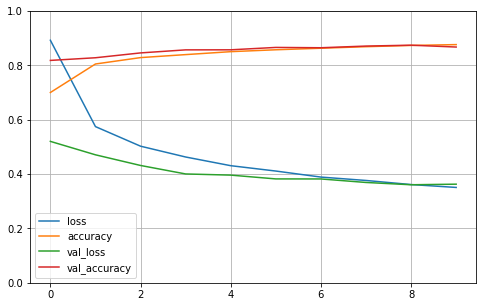

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
#    selu缓解梯度消失

In [9]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.40213441848754883, 0.8585000038146973]